### Methode du modèle hiérarchique

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pandas as pd

# Configuration des plages hiérarchiques
RANGE_MAPPING = {
    0: list(range(1, 10)),    # 1-9
    1: list(range(10, 21)),   # 10-20
    2: list(range(21, 32))    # 21-31
}

def digit_to_range(digit):
    """Convertit un chiffre (1-31) vers sa plage (0, 1, ou 2)"""
    if 1 <= digit <= 9:
        return 0
    elif 10 <= digit <= 20:
        return 1
    elif 21 <= digit <= 31:
        return 2
    else:
        raise ValueError(f"Chiffre {digit} hors plage valide (1-31)")

def digit_to_local_index(digit):
    """Convertit un chiffre vers son index local dans sa plage"""
    range_id = digit_to_range(digit)
    return RANGE_MAPPING[range_id].index(digit)

class DigitDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples_per_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Parcourir tous les dossiers digit_1 à digit_31
        for digit in range(1, 32):
            digit_dir = os.path.join(root_dir, f'digit_{digit}')
            if os.path.exists(digit_dir):
                img_files = [f for f in os.listdir(digit_dir) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                # Limiter le nombre d'échantillons par classe pour économiser la RAM
                if max_samples_per_class:
                    img_files = img_files[:max_samples_per_class]
                
                for img_file in img_files:
                    img_path = os.path.join(digit_dir, img_file)
                    self.samples.append((img_path, digit))
        
        print(f"Dataset chargé: {len(self.samples)} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, digit = self.samples[idx]
        
        # Charger et redimensionner immédiatement pour économiser la mémoire 
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Labels hiérarchiques
        range_label = digit_to_range(digit)
        local_label = digit_to_local_index(digit)
        
        return image, {
            'digit': digit - 1,  # 0-30 pour compatibilité
            'range': range_label,
            'local': local_label
        }

class LightweightHierarchicalModel(nn.Module):
    def __init__(self, input_channels=3, base_features=32):  # Réduit de 64 à 32
        super(LightweightHierarchicalModel, self).__init__()
        
        # Extracteur de caractéristiques 
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_channels, base_features, 3, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
    
            nn.Conv2d(base_features, base_features*2, 3, padding=1),
            nn.BatchNorm2d(base_features*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(base_features*2, base_features*3, 3, padding=1),
            nn.BatchNorm2d(base_features*3),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((2, 2))  
        )
        
        # Taille réduite des features
        feature_size = base_features * 3 * 2 * 2  # 96 * 4 
        
        # Classificateur de plage (niveau 1) 
        self.range_classifier = nn.Sequential(
            nn.Linear(feature_size, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  
        )
        
        # Classificateurs locaux (niveau 2) 
        self.local_classifiers = nn.ModuleDict({
            'range_0': nn.Sequential(  # 1-9 (9 classes)
                nn.Linear(feature_size + 3, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(128, 9)
            ),
            'range_1': nn.Sequential(  # 10-20 (11 classes)
                nn.Linear(feature_size + 3, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(128, 11)
            ),
            'range_2': nn.Sequential(  # 21-31 (11 classes)
                nn.Linear(feature_size + 3, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(128, 11)
            )
        })
    
    def forward(self, x):
        # Extraction des caractéristiques
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        
        # Prédiction de la plage
        range_logits = self.range_classifier(features)
        range_probs = F.softmax(range_logits, dim=1)
        
        # Prédictions locales pour chaque plage
        local_outputs = {}
        combined_features = torch.cat([features, range_logits], dim=1)
        
        for range_id in range(3):
            classifier_name = f'range_{range_id}'
            local_logits = self.local_classifiers[classifier_name](combined_features)
            local_outputs[range_id] = local_logits
        
        return {
            'range_logits': range_logits,
            'range_probs': range_probs,
            'local_outputs': local_outputs
        }
    
    def predict(self, x):
        """Prédiction finale combinant les deux niveaux"""
        with torch.no_grad():
            outputs = self.forward(x)
            
            # Prédiction de plage
            predicted_ranges = torch.argmax(outputs['range_logits'], dim=1)
            
            batch_size = x.size(0)
            final_predictions = []
            
            for i in range(batch_size):
                range_pred = predicted_ranges[i].item()
                local_logits = outputs['local_outputs'][range_pred][i:i+1]
                local_pred = torch.argmax(local_logits, dim=1).item()
                
                # Convertir vers le chiffre final
                final_digit = RANGE_MAPPING[range_pred][local_pred]
                final_predictions.append(final_digit)
            
            return torch.tensor(final_predictions)

🚀 Modèle Hiérarchique Optimisé CPU - 8GB RAM
📁 Création des data loaders...
Dataset chargé: 4650 images
🧠 Initialisation du modèle léger...
📊 Nombre de paramètres: 285,890
🏋️ Début de l'entraînement optimisé CPU...
Epoch 1/15: Train Loss: 0.7185, Val Loss: 0.0502, Val Acc: 3.12%
Epoch 2/15: Train Loss: 0.0989, Val Loss: 0.0017, Val Acc: 0.00%
Epoch 3/15: Train Loss: 0.0542, Val Loss: 0.0007, Val Acc: 0.00%
Epoch 4/15: Train Loss: 0.0456, Val Loss: 0.0005, Val Acc: 0.00%
Epoch 5/15: Train Loss: 0.0401, Val Loss: 0.0002, Val Acc: 0.00%
Epoch 6/15: Train Loss: 0.0347, Val Loss: 0.0001, Val Acc: 0.00%
Epoch 7/15: Train Loss: 0.0354, Val Loss: 0.0001, Val Acc: 0.00%
Epoch 8/15: Train Loss: 0.0271, Val Loss: 0.0000, Val Acc: 0.00%
Epoch 9/15: Train Loss: 0.0319, Val Loss: 0.0000, Val Acc: 0.00%
Epoch 10/15: Train Loss: 0.0293, Val Loss: 0.0001, Val Acc: 0.00%
Epoch 11/15: Train Loss: 0.0139, Val Loss: 0.0000, Val Acc: 0.00%
Epoch 12/15: Train Loss: 0.0154, Val Loss: 0.0000, Val Acc: 0.00%
Ep

C:\Users\kouma\AppData\Local\Temp\ipykernel_4204\1969336718.py:520: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\kouma\AppData\Local\Temp\ipykernel_4204\1969336718.py:520: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\kouma\AppData\Local\Temp\ipykernel_4204\1969336718.py:520: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\kouma\AppData\Local\Temp\ipykernel_4204\1969336718.py:520: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from 

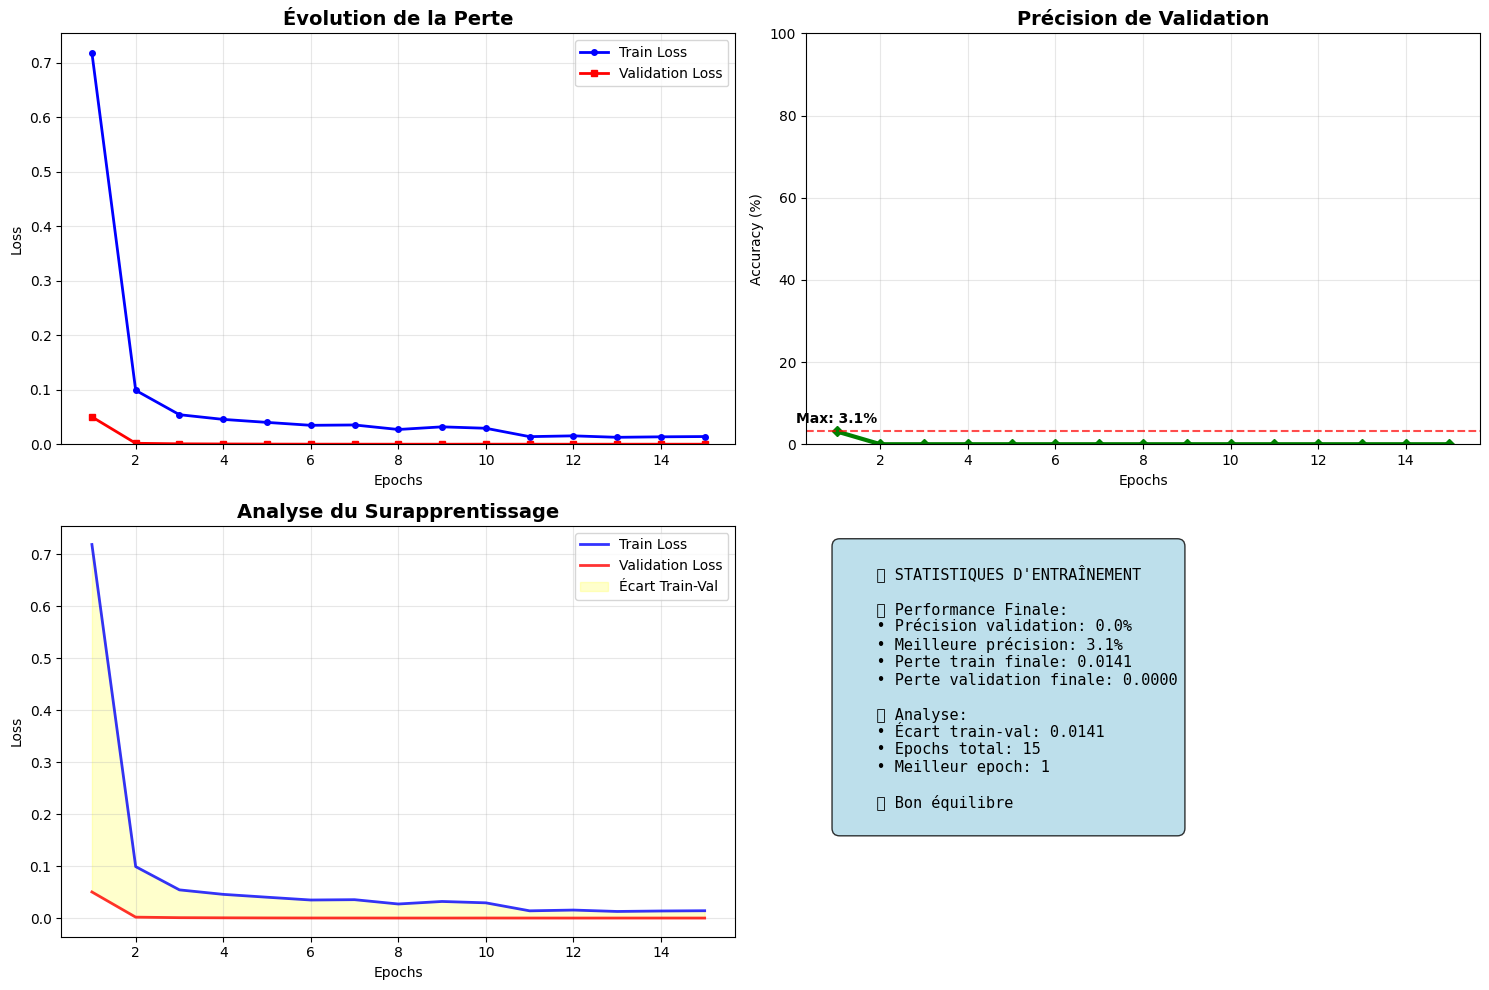

📊 Évaluation du modèle...

🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE
📊 Génération des prédictions pour matrices de confusion...


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


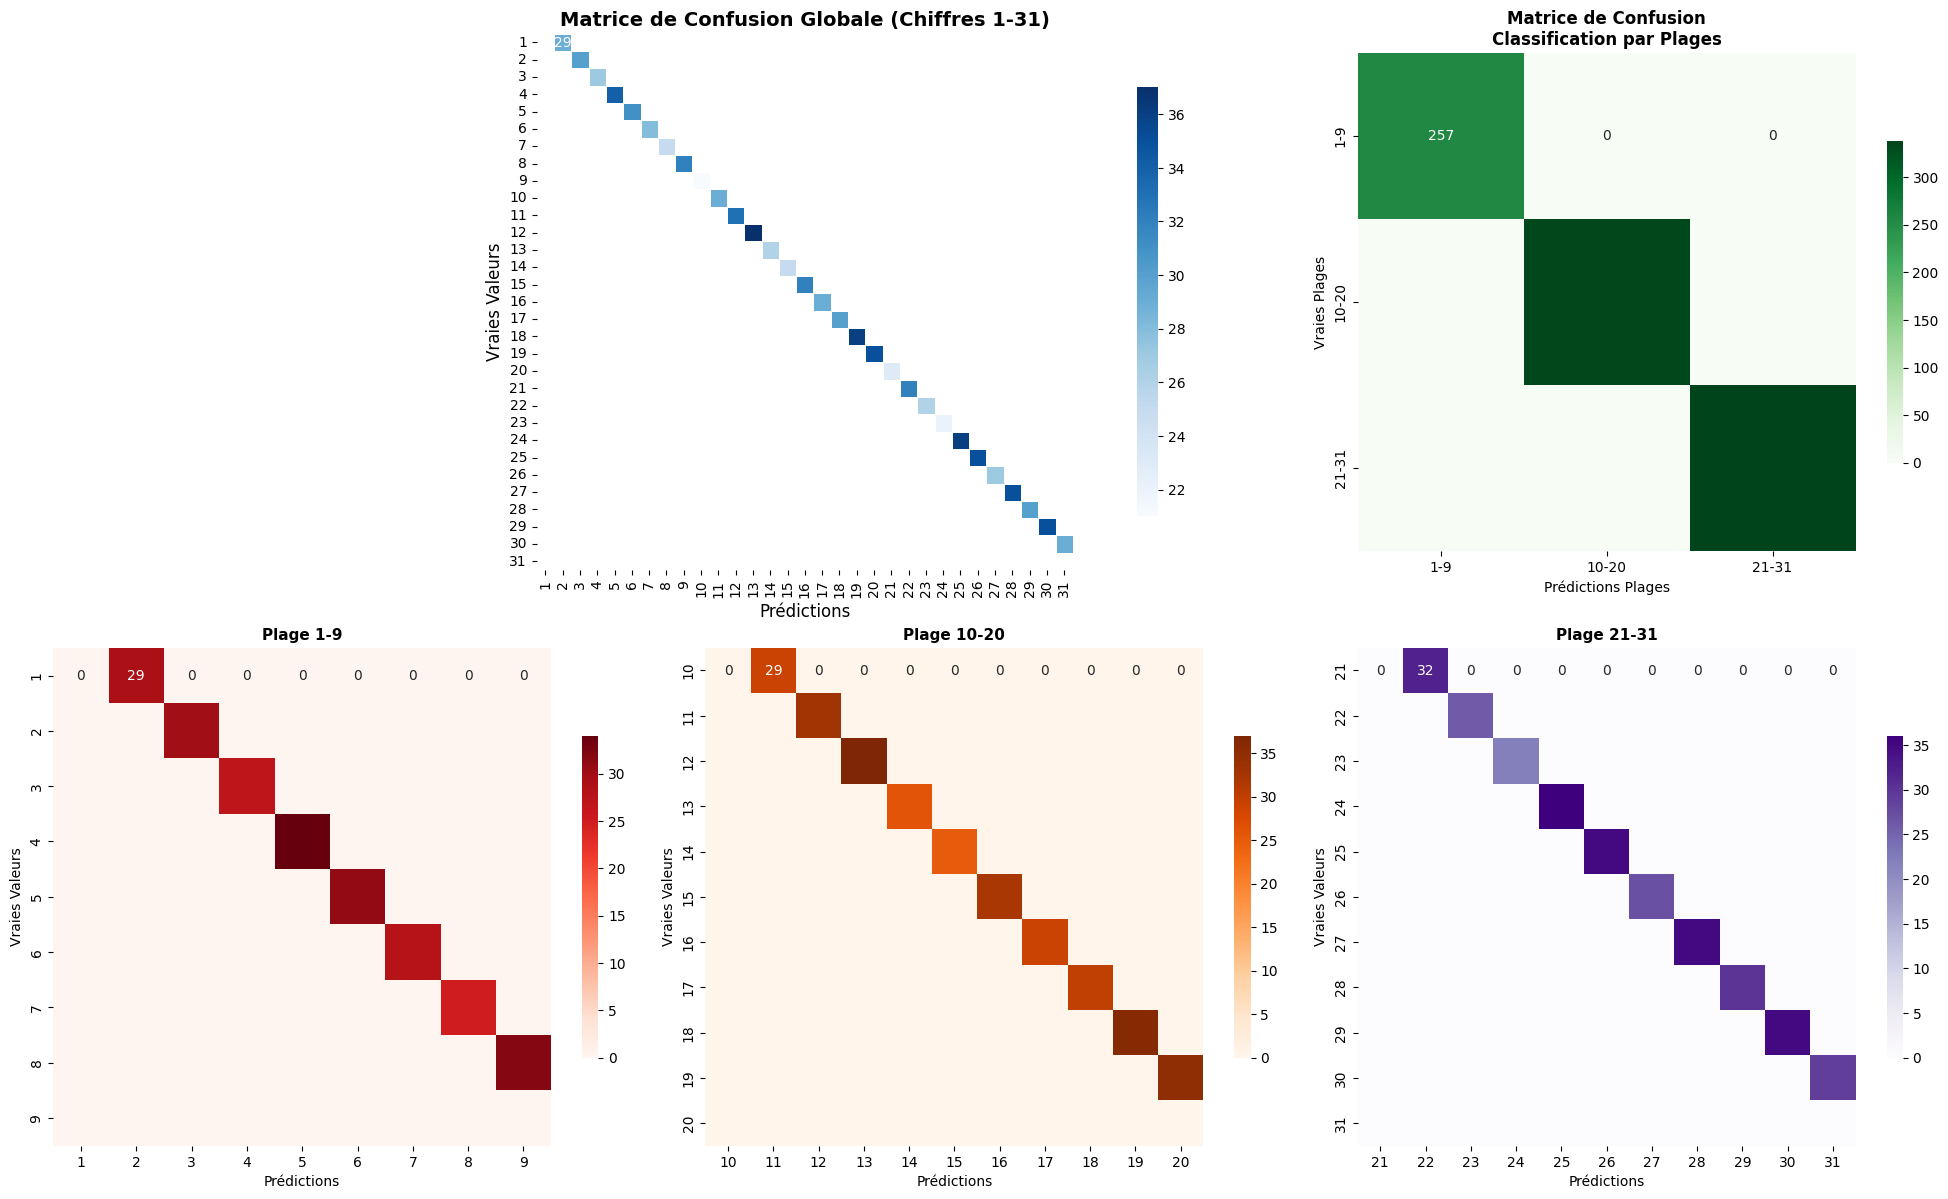


📋 RAPPORT DE CLASSIFICATION GLOBAL:
--------------------------------------------------
              precision    recall  f1-score   support

           1      0.000     0.000     0.000      29.0
           2      0.000     0.000     0.000      30.0
           3      0.000     0.000     0.000      27.0
           4      0.000     0.000     0.000      34.0
           5      0.000     0.000     0.000      31.0
           6      0.000     0.000     0.000      28.0
           7      0.000     0.000     0.000      25.0
           8      0.000     0.000     0.000      32.0
           9      0.000     0.000     0.000      21.0
          10      0.000     0.000     0.000      29.0
          11      0.000     0.000     0.000      33.0
          12      0.000     0.000     0.000      37.0
          13      0.000     0.000     0.000      26.0
          14      0.000     0.000     0.000      25.0
          15      0.000     0.000     0.000      32.0
          16      0.000     0.000     0.000    

c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Master\Se

In [4]:


class HierarchicalLoss(nn.Module):
    def __init__(self, range_weight=1.0, local_weight=1.0):
        super(HierarchicalLoss, self).__init__()
        self.range_weight = range_weight
        self.local_weight = local_weight
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, outputs, targets):
        range_loss = self.ce_loss(outputs['range_logits'], targets['range'])
        
        # Perte locale pondérée par plage
        local_loss = 0
        batch_size = targets['range'].size(0)
        
        for i in range(batch_size):
            true_range = targets['range'][i].item()
            local_logits = outputs['local_outputs'][true_range][i:i+1]
            local_target = targets['local'][i:i+1]
            local_loss += self.ce_loss(local_logits, local_target)
        
        local_loss /= batch_size
        
        total_loss = self.range_weight * range_loss + self.local_weight * local_loss
        
        return {
            'total_loss': total_loss,
            'range_loss': range_loss,
            'local_loss': local_loss
        }

def train_model_cpu_optimized(model, train_loader, val_loader, num_epochs=30, lr=0.001):
    """Version optimisée pour CPU avec gestion mémoire"""
    device = torch.device('cpu')  
    model.to(device)
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    criterion = HierarchicalLoss(range_weight=0.3, local_weight=0.7)
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}
            
            optimizer.zero_grad()
            outputs = model(data)
            loss_dict = criterion(outputs, targets)
            loss = loss_dict['total_loss']
            
            loss.backward()
            # Gradient clipping léger
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
            
            # Nettoyage mémoire périodique
            if batch_idx % 20 == 0:
                del outputs, loss_dict, loss
                gc.collect()
        
        # Validation avec économie de mémoire
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device)
                targets = {k: v.to(device) for k, v in targets.items()}
                
                outputs = model(data)
                loss_dict = criterion(outputs, targets)
                val_loss += loss_dict['total_loss'].item()
                
                # Calcul de précision
                predictions = model.predict(data)
                correct += (predictions == targets['digit']).sum().item()
                total += targets['digit'].size(0)
                
                # Nettoyage immédiat
                del outputs, loss_dict, predictions
        
        train_loss /= batch_count
        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Nettoyage mémoire après chaque epoch
        gc.collect()
    
    return history

def create_memory_efficient_loaders(dataset_path, batch_size=16, val_split=0.2, max_samples=200):
    """Data loaders optimisés pour économiser la mémoire"""
    
    # Transformations légères
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Plus petite taille
        transforms.RandomRotation(10),  # Augmentation réduite
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Dataset avec limitation d'échantillons
    full_dataset = DigitDataset(dataset_path, transform=train_transform, max_samples_per_class=max_samples)
    
    # Division train/validation
    dataset_size = len(full_dataset)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    # Appliquer les bonnes transformations
    val_dataset.dataset.transform = val_transform
    
    # DataLoaders avec moins de workers pour économiser la mémoire
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader

def plot_confusion_matrices(model, test_loader, save_path='confusion_matrices.png'):
    """Génère et affiche les matrices de confusion"""
    model.eval()
    all_predictions = []
    all_targets = []
    range_predictions = []
    range_targets = []
    
    print("📊 Génération des prédictions pour matrices de confusion...")
    
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            predictions = model.predict(data)
            
            all_predictions.extend(predictions.numpy())
            all_targets.extend(targets['digit'].numpy())
            
            range_preds = torch.argmax(outputs['range_logits'], dim=1)
            range_predictions.extend(range_preds.numpy())
            range_targets.extend(targets['range'].numpy())
    
    # Conversion pour avoir les vrais chiffres (1-31)
    final_predictions = [p + 1 for p in all_predictions]
    final_targets = [t + 1 for t in all_targets]
    
    # Configuration du style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Matrice de confusion globale 
    plt.subplot(2, 3, (1, 2))
    cm_global = confusion_matrix(final_targets, final_predictions, labels=range(1, 32))
    
    # Créer un masque pour les valeurs nulles
    mask = cm_global == 0
    
    sns.heatmap(cm_global, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                square=True,
                cbar_kws={'shrink': 0.8},
                xticklabels=range(1, 32),
                yticklabels=range(1, 32),
                mask=mask,
                linewidths=0.5)
    
    plt.title('Matrice de Confusion Globale (Chiffres 1-31)', fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies Valeurs', fontsize=12)
    
    # 2. Matrice de confusion par plages
    plt.subplot(2, 3, 3)
    cm_ranges = confusion_matrix(range_targets, range_predictions)
    
    sns.heatmap(cm_ranges, 
                annot=True, 
                fmt='d', 
                cmap='Greens',
                square=True,
                xticklabels=['1-9', '10-20', '21-31'],
                yticklabels=['1-9', '10-20', '21-31'],
                cbar_kws={'shrink': 0.6})
    
    plt.title('Matrice de Confusion\nClassification par Plages', fontsize=12, fontweight='bold')
    plt.xlabel('Prédictions Plages')
    plt.ylabel('Vraies Plages')
    
    # 3-5. Matrices de confusion par plage individuelle
    range_names = ['Plage 1-9', 'Plage 10-20', 'Plage 21-31']
    colors = ['Reds', 'Oranges', 'Purples']
    
    for range_id in range(3):
        plt.subplot(2, 3, 4 + range_id)
        
        range_digits = RANGE_MAPPING[range_id]
        mask = [t in range_digits for t in final_targets]
        
        if any(mask):
            range_preds = [final_predictions[i] for i, m in enumerate(mask) if m]
            range_targs = [final_targets[i] for i, m in enumerate(mask) if m]
            
            cm_range = confusion_matrix(range_targs, range_preds, labels=range_digits)
            
            sns.heatmap(cm_range, 
                        annot=True, 
                        fmt='d', 
                        cmap=colors[range_id],
                        square=True,
                        xticklabels=range_digits,
                        yticklabels=range_digits,
                        cbar_kws={'shrink': 0.6})
            
            plt.title(f'{range_names[range_id]}', fontsize=11, fontweight='bold')
            plt.xlabel('Prédictions')
            plt.ylabel('Vraies Valeurs')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return final_targets, final_predictions, range_targets, range_predictions

def plot_training_history(history):
    """Graphiques détaillés de l'entraînement"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Évolution des pertes
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss', marker='o', markersize=4)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
    axes[0, 0].set_title('Évolution de la Perte', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(bottom=0)
    
    # 2. Précision de validation
    axes[0, 1].plot(epochs, history['val_acc'], 'g-', linewidth=3, marker='D', markersize=5)
    axes[0, 1].set_title('Précision de Validation', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 100)
    
    # ligne de la meilleure performance
    best_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_acc) + 1
    axes[0, 1].axhline(y=best_acc, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].text(best_epoch, best_acc + 2, f'Max: {best_acc:.1f}%', 
                    fontweight='bold', ha='center')
    
    # 3. Comparaison Train vs Validation Loss 
    axes[1, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss', alpha=0.8)
    axes[1, 0].plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    axes[1, 0].fill_between(epochs, history['train_loss'], history['val_loss'], 
                           alpha=0.2, color='yellow', label='Écart Train-Val')
    axes[1, 0].set_title('Analyse du Surapprentissage', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Statistiques finales
    axes[1, 1].axis('off')
    
    # Calculs statistiques
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_acc = history['val_acc'][-1]
    best_val_acc = max(history['val_acc'])
    overfitting = abs(final_val_loss - final_train_loss)
    
    # Texte statistiques
    stats_text = f"""
    📊 STATISTIQUES D'ENTRAÎNEMENT
    
    🎯 Performance Finale:
    • Précision validation: {final_val_acc:.1f}%
    • Meilleure précision: {best_val_acc:.1f}%
    • Perte train finale: {final_train_loss:.4f}
    • Perte validation finale: {final_val_loss:.4f}
    
    📈 Analyse:
    • Écart train-val: {overfitting:.4f}
    • Epochs total: {len(epochs)}
    • Meilleur epoch: {best_epoch}
    
    {'✅ Bon équilibre' if overfitting < 0.5 else '⚠️  Possible surapprentissage' if overfitting < 1.0 else '❌ Surapprentissage détecté'}
    """
    
    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=11, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    
    plt.show()

def evaluate_model_detailed(model, test_loader):
    """Évaluation détaillée avec toutes les métriques"""
    print("\n" + "="*60)
    print("🔍 ÉVALUATION DÉTAILLÉE DU MODÈLE")
    print("="*60)
    
    # Générer matrices de confusion et obtenir prédictions
    final_targets, final_predictions, range_targets, range_predictions = plot_confusion_matrices(model, test_loader)
    
    # Rapport de classification global
    print("\n📋 RAPPORT DE CLASSIFICATION GLOBAL:")
    print("-" * 50)
    print(classification_report(final_targets, final_predictions, digits=3))
    
    # Métriques par plage
    print("\n🎯 PRÉCISION PAR PLAGE:")
    print("-" * 30)
    range_acc = np.mean(np.array(range_predictions) == np.array(range_targets))
    print(f"Classification de plages: {range_acc*100:.2f}%")
    
    # Analyse détaillée par plage
    for range_id in range(3):
        range_digits = RANGE_MAPPING[range_id]
        mask = [t in range_digits for t in final_targets]
        if any(mask):
            range_preds = [final_predictions[i] for i, m in enumerate(mask) if m]
            range_targs = [final_targets[i] for i, m in enumerate(mask) if m]
            range_local_acc = np.mean(np.array(range_preds) == np.array(range_targs))
            
            # Erreurs dans cette plage
            errors = sum(1 for p, t in zip(range_preds, range_targs) if p != t)
            total = len(range_targs)
            
            print(f"  Plage {range_digits[0]:2d}-{range_digits[-1]:2d}: {range_local_acc*100:5.1f}% ({total-errors:3d}/{total:3d} correct)")
    
    # Analyse des erreurs les plus fréquentes
    print("\n❌ ERREURS LES PLUS FRÉQUENTES:")
    print("-" * 40)
    
    errors = []
    for true, pred in zip(final_targets, final_predictions):
        if true != pred:
            errors.append((true, pred))
    
    if errors:
        from collections import Counter
        error_counts = Counter(errors)
        top_errors = error_counts.most_common(10)
        
        for (true_val, pred_val), count in top_errors:
            print(f"  {true_val:2d} → {pred_val:2d}: {count:2d} fois")
    
    # Précision globale
    global_acc = np.mean(np.array(final_predictions) == np.array(final_targets))
    print(f"\n🏆 PRÉCISION GLOBALE: {global_acc*100:.2f}%")
    
    return {
        'global_accuracy': global_acc,
        'range_accuracy': range_acc,
        'predictions': final_predictions,
        'targets': final_targets,
        'range_predictions': range_predictions,
        'range_targets': range_targets
    }

# Fonction principale optimisée
def main():
    print("🚀 Modèle Hiérarchique Optimisé CPU - 8GB RAM")
    print("=" * 50)
    
    # Configuration optimisée pour votre machine
    dataset_path = "dataset_augmented"
    batch_size = 12  # Petit batch pour économiser la RAM
    num_epochs = 15  
    learning_rate = 0.003  
    max_samples_per_class = 150  # Limiter les échantillons
    
    print("📁 Création des data loaders...")
    train_loader, val_loader = create_memory_efficient_loaders(
        dataset_path, batch_size, max_samples=max_samples_per_class
    )
    
    print(" Initialisation du modèle léger...")
    model = LightweightHierarchicalModel()
    
    # Afficher la taille du modèle
    total_params = sum(p.numel() for p in model.parameters())
    print(f"📊 Nombre de paramètres: {total_params:,}")
    
    print("🏋️ Début de l'entraînement optimisé CPU...")
    history = train_model_cpu_optimized(model, train_loader, val_loader, num_epochs, learning_rate)
    
    # Sauvegarde
    torch.save(model.state_dict(), 'lightweight_hierarchical_model.pth')
    print("💾 Modèle sauvegardé!")
    print("📈 Traçage de l'historique d'entraînement...")
    plot_training_history(history)
    print("📊 Évaluation du modèle...")
    test_loader = DataLoader(val_loader.dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    evaluate_model_detailed(model, test_loader)
    

    
   
    
    print("✅ Entraînement terminé avec succès!")


main()

### Test du model 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

def predict_digits_in_folder(rois_folder, model_path='lightweight_hierarchical_model.pth'):
    """
    Prédit les chiffres (1-31) pour toutes les images dans le dossier extracted_rois.
    
    Parameters:
    - rois_folder: Chemin vers le dossier contenant les images ROI
    - model_path: Chemin vers le fichier de poids du modèle
    
    Returns:
    - Liste de dictionnaires avec filename et predicted_digit
    """
    list_digit = []
    # Vérifier si le dossier existe
    if not os.path.exists(rois_folder):
        print(f"Erreur : Le dossier '{rois_folder}' n'existe pas.")
        return []
    
    # Charger le modèle
    device = torch.device('cpu')  # Forcer CPU comme dans votre code
    model = LightweightHierarchicalModel()
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
    except Exception as e:
        print(f"Erreur lors du chargement du modèle : {e}")
        return []
    
    # Transformation des images
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Liste des résultats
    results = []
    
    # Filtrer les fichiers image
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(rois_folder) if f.lower().endswith(valid_extensions)]
    
    if not image_files:
        print(f"Aucune image trouvée dans '{rois_folder}'.")
        return []
    
    print(f"🚀 Prédiction pour {len(image_files)} images dans '{rois_folder}'...")
    
    # Prédire pour chaque image
    for img_file in sorted(image_files):  # Tri pour ordre cohérent
        img_path = os.path.join(rois_folder, img_file)
        
        try:
            # Charger et transformer l'image
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)  # Ajouter dimension batch
            
            # Prédiction
            with torch.no_grad():
                prediction = model.predict(image_tensor)
                predicted_digit = prediction.item()  # Chiffre de 1 à 31
            
            results.append({
                'filename': img_file,
                'predicted_digit': predicted_digit
            })
            list_digit.append(predicted_digit)
            print(f"✅ {img_file}: Chiffre prédit = {predicted_digit}")
            
        except Exception as e:
            print(f"⚠️ Erreur pour {img_file} : {e}")
            continue
    
    print(f"\n🏁 Prédictions terminées : {len(results)} images traitées.")
    return results, list_digit


if __name__ == "__main__":
    # Chemin vers le dossier extracted_rois
    rois_folder = "extracted_rois"
    
    # Lance la prédiction
    predictions,list_digit = predict_digits_in_folder(rois_folder)

    #verifie si il y a les chiffre de 1 a 31
    if len(set(list_digit)) == 31:
        print("✅ Tous les chiffres de 1 à 31 sont présents dans les prédictions.")
    else:
        # Afficher les chiffres manquants
        all_digits = set(range(1, 32))
        missing_digits = all_digits - set(list_digit)
        print(f"⚠️ Chiffres manquants dans les prédictions : {sorted(missing_digits)}")

    
   

🚀 Prédiction pour 62 images dans 'extracted_rois'...
✅ image_roi_01.jpg: Chiffre prédit = 1
✅ image_roi_02.jpg: Chiffre prédit = 2
✅ image_roi_03.jpg: Chiffre prédit = 3
✅ image_roi_04.jpg: Chiffre prédit = 4
✅ image_roi_05.jpg: Chiffre prédit = 5
✅ image_roi_06.jpg: Chiffre prédit = 6
✅ image_roi_07.jpg: Chiffre prédit = 7
✅ image_roi_08.jpg: Chiffre prédit = 8
✅ image_roi_09.jpg: Chiffre prédit = 9
✅ image_roi_10.jpg: Chiffre prédit = 10
✅ image_roi_11.jpg: Chiffre prédit = 11
✅ image_roi_12.jpg: Chiffre prédit = 12
✅ image_roi_13.jpg: Chiffre prédit = 13
✅ image_roi_14.jpg: Chiffre prédit = 14
✅ image_roi_15.jpg: Chiffre prédit = 15
✅ image_roi_16.jpg: Chiffre prédit = 16
✅ image_roi_17.jpg: Chiffre prédit = 17
✅ image_roi_18.jpg: Chiffre prédit = 18
✅ image_roi_19.jpg: Chiffre prédit = 19
✅ image_roi_20.jpg: Chiffre prédit = 20
✅ image_roi_21.jpg: Chiffre prédit = 21
✅ image_roi_22.jpg: Chiffre prédit = 22
✅ image_roi_23.jpg: Chiffre prédit = 23
✅ image_roi_24.jpg: Chiffre prédit =